In [4]:
import networkx as nx
import numpy as np

In [5]:
G = nx.complete_graph(20)
X = nx.shortest_simple_paths(G, 0, 5)
k = 5
for counter, path in enumerate(X):
     print(path)
     if counter == k-1:
         break

[0, 5]
[0, 1, 5]
[0, 2, 5]
[0, 3, 5]
[0, 4, 5]
[0, 6, 5]


In [98]:
from itertools import compress


def nodes_to_edges_path(nl):
    el = []
    for i in range(1,len(nl)):
        el.append((nl[i-1], nl[i]))
    return el

def edges_to_binary_vector(el, edges):
    ev = np.zeros(len(edges))
    
    for e in el:
        for ei, ee in enumerate(edges):
            if set(e) == set(ee):
                ev[ei] = 1
                break
        
        
    return(ev)

def binary_vector_to_edges(ev, edges):
    return list(compress(edges, ev))
        
        

In [103]:
def sestavi_QBtca(ZK, G, st_alternativ = 4):
    edges = G.edges()
    edges_data = G.edges(data=True)
    Q = None
    B = None
    
    for i in range(len(ZK)):
        z,k,_ = ZK[i]
        X = nx.shortest_simple_paths(G, z, k)
        for counter, path in enumerate(X):
            col = edges_to_binary_vector(nodes_to_edges_path(path), list(edges))
            Q = col if Q is None else np.column_stack([Q,col])
            if counter == st_alternativ-1:
                break
        b = np.repeat(np.eye(len(ZK),1,-i), counter+1, axis=1)
        B = b if B is None else np.column_stack([B,b])
    
    t = [d["t"] for _,_,d in edges_data]
    c = [d["c"] for _,_,d in edges_data]
    
    a = [ai for _,_,ai in ZK]
    return(Q,B,t,c,a)

[(1, 3), (3, 4), (3, 5), (3, 1), (3, 2), (2, 3), (4, 5), (4, 3), (5, 6), (5, 7), (5, 4), (5, 3), (6, 5), (7, 5)]
[[1. 1. 0. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] [[1. 1. 0. 0.]
 [0. 0. 1. 1.]] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] [1, 1]


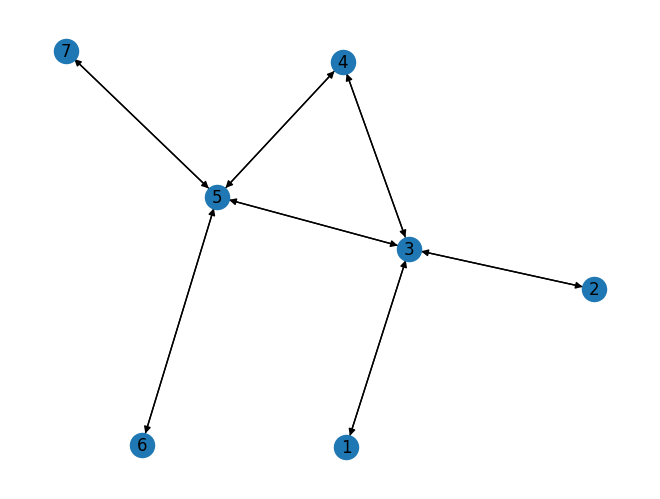

In [137]:
# debug
G = nx.DiGraph()
#G.add_nodes_from(range(9))
G.add_edges_from([(1,3),(2,3),(3,4),(4,5),(3,5),(5,6),(5,7),(3,1),(3,2),(4,3),(5,4),(5,3),(6,5),(7,5)])
#G.add_weighted_edges_from([(1,3),(2,3),(3,4),(4,5),(3,5),(5,6),(5,7)])
print(G.edges())
#nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, name = 'c')
nx.set_edge_attributes(G, {e: i for i,  e in enumerate(G.edges())}, name = 'c')
nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, name = 't')
x = list(G.edges)
#print(G.number_of_edges())

nx.draw(G,with_labels=True)

ZK = [(1,6,1),(2,7,1)] # z,k,a

Q,B,t,c,a = sestavi_QBtca(ZK, G)
print(Q,B,t,c,a)

        


In [138]:
from scipy.optimize import linprog

#c = [1, 3, 1, 1, 3, 1, 3]
#t = [1, 1, 1, 1, 0.5, 1, 1]
#Q = [[1, 1, 0, 0], [0, 0, 1, 1], [1, 0, 1, 0], [1, 0, 1, 0], [0, 1, 0, 1], [1, 1, 0, 0], [0, 0, 1, 1]]
#B = [[1, 1, 0, 0], [0, 0, 1, 1]]

Q,B,t,c,a = sestavi_QBtca(ZK, G)


f = np.dot(t, Q)

# x = linprog(f=f,A=Q,b=c,Aeq=selector,beq=unit,lb=0,ub=1)
res = linprog(f, A_ub=Q, b_ub=c, A_eq=B, b_eq=a, integrality=1)

print(res.fun, res.x, res.message)
neki = Q[:,res.x == 1]
for i in range(neki.shape[1]):
    print(binary_vector_to_edges(neki[:,i],G.edges()))



None None The problem is infeasible. (HiGHS Status 8: model_status is Infeasible; primal_status is At lower/fixed bound)


In [105]:
import networkx as nx
import osmnx as ox

ox.config(use_cache=True, log_console=True)

# download street network data from OSM and construct a MultiDiGraph model
G = ox.graph_from_point((37.79, -122.41), dist=100, network_type="drive")

# impute edge (driving) speeds and calculate edge traversal times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# you can convert MultiDiGraph to/from geopandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.utils_graph.get_digraph(G, weight="travel_time")

# calculate node betweenness centrality, weighted by travel time
bc = nx.betweenness_centrality(D, weight="travel_time", normalized=True)
nx.set_node_attributes(G, values=bc, name="bc")

# plot the graph, coloring nodes by betweenness centrality
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color="#333333"
)

# save graph to shapefile, geopackage, or graphml
ox.save_graph_shapefile(G, filepath="./graph_shapefile/")
ox.save_graph_geopackage(G, filepath="./graph.gpkg")
ox.save_graphml(G, filepath="./graph.graphml")

/home/lema/.local/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


ValueError: this graph's edges have no preexisting `maxspeed` attribute values so you must pass `hwy_speeds` or `fallback` arguments.

<class 'networkx.classes.multidigraph.MultiDiGraph'>


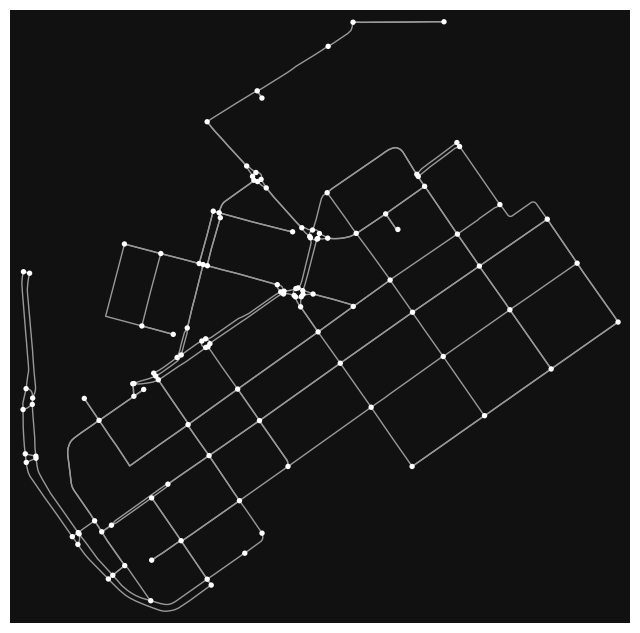

                  y          x  street_count highway  \
osmid                                                  
25216594  60.164794  24.921057             4     NaN   
25238874  60.163665  24.921028             4     NaN   
25238944  60.164631  24.921286             3     NaN   
25291537  60.164325  24.937023             4     NaN   
25291564  60.165948  24.941674             4     NaN   

                           geometry  
osmid                                
25216594  POINT (24.92106 60.16479)  
25238874  POINT (24.92103 60.16366)  
25238944  POINT (24.92129 60.16463)  
25291537  POINT (24.93702 60.16433)  
25291564  POINT (24.94167 60.16595)  
                                                                     osmid  \
u        v          key                                                      
25216594 1372425714 0                                             23856784   
25238874 1372425713 0                                 [29977177, 30470347]   
25238944 25216594   0        

<AxesSubplot: >

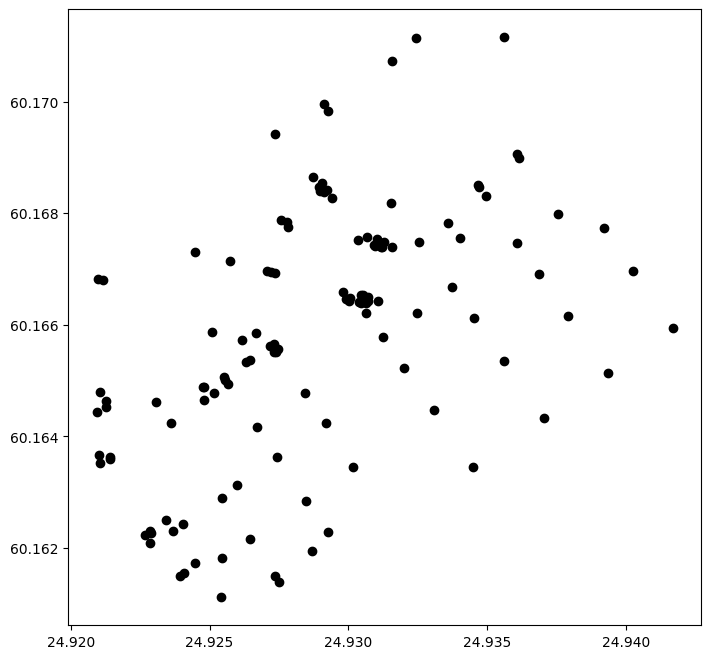

In [32]:
import osmnx as ox
import matplotlib.pyplot as plt

place = 'Kamppi, Helsinki, Finland'
graph = ox.graph_from_place(place,network_type='drive')
# graph = ox.graph_from_point((37.79, -122.41), dist=750, network_type="drive")
print(type(graph))
# Plot the streets
fig, ax = ox.plot_graph(graph)

# Retrieve nodes and edges
#G = ox.add_edge_travel_times(G)
nodes, edges = ox.graph_to_gdfs(graph)
print(nodes.head())
print(edges.head())

# Plot the nodes
fig, ax = plt.subplots(figsize=(12,8))
nodes.plot(ax=ax, facecolor='black')

#edges.where(edges["max_speed"] is not np.nan)

In [125]:
# recimo, da nastavimo c na stevilo pasov, t pa na dolzino odseka
g = nx.DiGraph(graph)
l = list(g.edges(data=True))
#nx.set_edge_attributes(g, {e: g.edges()[e]["lanes"] for e in g.edges()}, name = 'c')
nx.set_edge_attributes(g, {e: 1 for e in g.edges()}, name = 'c')
# for e in g.edges():
#     try:
#         print(g.edges()[e]["lanes"])
#     except:
#         print(g.edges()[e])
nx.set_edge_attributes(g, {e: g.edges()[e]["length"] for e in g.edges()}, name = 't')
# plt.hist([l[i][2]["highway"] for i in range(len(l))])
# set([l[i][2]["highway"] for i in range(len(l))])
# LIST_OF_ROAD_TYPES = ['motorway','trunk','primary','primary_link','secondary','tertiary','unclassified','living_street','residential']


In [132]:
l[0]

(25216594,
 1372425714,
 {'osmid': 23856784,
  'oneway': True,
  'lanes': '2',
  'name': 'Mechelininkatu',
  'highway': 'primary',
  'maxspeed': '40',
  'reversed': False,
  'length': 40.885,
  'geometry': <LINESTRING (24.921 60.165, 24.921 60.165, 24.921 60.165, 24.921 60.165, 24....>,
  'c': 1,
  't': 40.885})

In [127]:

# 0:
# 25291537
# 1:
# 25291565
# for e in g.edges():
#     if g.edges[e]["oneway"] == False:
#         pass
# ta je oneway = False in istocasno je podvojen tko da ne rabm podvajat
print((25291537,25291565) in g.edges())
(25291565,25291537) in g.edges()

True


True

In [128]:
list(g.nodes())

[25216594,
 25238874,
 25238944,
 25291537,
 25291564,
 25291565,
 25291591,
 25292473,
 25416262,
 25416263,
 25416267,
 56113314,
 56115897,
 56116937,
 57743854,
 60004721,
 60069401,
 60070287,
 60072524,
 60170470,
 60170471,
 60278325,
 103062861,
 148875335,
 149030035,
 149030036,
 149030037,
 149143065,
 150983569,
 159619609,
 175832743,
 232165213,
 258188404,
 258189020,
 266159806,
 266159814,
 266159899,
 267117317,
 267117319,
 268177652,
 282730717,
 282730727,
 282730739,
 282730959,
 282730985,
 282731082,
 295322365,
 301360197,
 313937382,
 313963185,
 314929251,
 315285583,
 319604907,
 319885318,
 319896278,
 337264937,
 434558043,
 529507770,
 529507771,
 568147264,
 659998488,
 724233128,
 724233143,
 724233172,
 846597945,
 846597947,
 846597954,
 846597959,
 949775435,
 979855770,
 979855795,
 979855850,
 1007980689,
 1008183915,
 1371748756,
 1371748760,
 1371750094,
 1371750095,
 1371750097,
 1371750099,
 1371751501,
 1371751505,
 1371751507,
 1371751516,
 1

In [129]:
from scipy.optimize import linprog

ZK = [(25216594,25238874,1),(2037356632,3177642345,1)]
Q,B,t,c,a = sestavi_QBtca(ZK, g)


f = np.dot(t, Q)

# x = linprog(f=f,A=Q,b=c,Aeq=selector,beq=unit,lb=0,ub=1)
res = linprog(f, A_ub=Q, b_ub=c, A_eq=B, b_eq=a, integrality=1)

print(res.fun, res.x, res.message)

427.687 [1. 1. 0. 0. 0.] Optimization terminated successfully. (HiGHS Status 7: Optimal)
